## AuxTel Nasmyth Rotator Torque Model.

Attempting to model the torque vs angle of the AuxTel Nasmyth2 rotator to aid with balancing.\
Craig Lage 06 - May - 2021

In [1]:
import numpy as np
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

In [17]:
# Basic quantities
Basic = {}
Basic['rDewar'] = 20.0 # Radius of Dewar in cm
Basic['nDewar'] = 100 # Number of segments making up the Dewar mass load
Basic['mDewar'] = 1.0 # Mass of each Dewar segment in kg
Basic['L'] = 50.0 # Side dimension of 4 strut pieces in cm
Basic['mSide'] = 5.0 # mass of 4 side struts in kg
Basic['friction'] =2000.0 # Magnitude of frictional component
Basic['W'] = 2.0 # Size of corners in cm
Basic['R'] = 1.0 # radius of Dewar segments in cm

In [3]:
def plotMasses(Basic, Adds, ax):
    ax.set_aspect(1.0)
    L = Basic['L']
    W = Basic['W']
    R = Basic['R']
    rDewar = Basic['rDewar']
    nDewar = Basic['nDewar']
    center1 = Rectangle((-0.1, -2.5), 0.2, 5.0, ec='black', fc='black')
    ax.add_patch(center1)
    center2 = Rectangle((-2.5, -0.1), 5.0, 0.2, ec='black', fc='black')
    ax.add_patch(center2)
    # Plot corners
    for signX in [-1.0,1.0]:
        for signY in [-1.0, 1.0]:
            corner = Rectangle((signX*L/2.0, signY/2.0*L), W, W, ec='black', fc='black')
            ax.add_patch(corner)
    theta = 0.0
    # Plot Dewar simulator
    for n in range(nDewar):
        theta += 2.0 * np.pi / float(nDewar)
        segment = Circle((rDewar * np.cos(theta), rDewar * np.sin(theta)), R, ec='black', fc='yellow')
        ax.add_patch(segment)  
    # Plot added weights
    for m,x,y in Adds:
        mass = Rectangle((x, y), W, W, ec='red', fc='red')
        ax.add_patch(mass)
    ax.set_xlim(-40,40)
    ax.set_ylim(-40,40)

In [24]:
def calculateTorque(Basic, Adds, ax, fudgeFactor=1.0):
    # The torque is RxF, which is basically just the x-corrdinate of the mass times the weight
    # We add in a frictional component and then add up the torques due to all of the masses
    g = 10.0
    L = Basic['L']
    W = Basic['W']
    R = Basic['R']
    rDewar = Basic['rDewar']
    nDewar = Basic['nDewar']
    nSteps = 500
    angles = []
    torques = []
    deltaPhi = 320.0 / float(nSteps)
    
    phi = -160.0
    for sign in [1.0,-1.0]:
        for n in range(nSteps):
            # First add in a constant frictional torque that opposes the motion
            torque = Basic['friction'] * sign
            c, s = np.cos(phi*np.pi/180.0), np.sin(phi*np.pi/180.0)
            # This is the rotation matrix that rotates (X,Y) into the current coordinates
            Rot = np.array(((c, s), (-s, c))) 
            # Torque due to corners
            for signX in [-1.0,1.0]:
                for signY in [-1.0, 1.0]:
                    coords = np.array([signX*L/2.0, signY/2.0*L])
                    rotated_coords = Rot.dot(coords)
                    x = rotated_coords[0]
                    torque -= Basic['mSide'] * g * x
            # Torque due to Dewar simulator
            theta = phi*np.pi/180.0
            for n in range(nDewar):
                theta += 2.0 * np.pi / float(nDewar)
                coords = np.array([rDewar * np.cos(theta), rDewar * np.sin(theta)])
                rotated_coords = Rot.dot(coords)
                x = rotated_coords[0]
                torque -= Basic['mSide'] * g * x
            # Torque due to added weights
            for m,x,y in Adds:
                coords = np.array([x, y])
                rotated_coords = Rot.dot(coords)
                x = rotated_coords[0]
                torque -= m * g * x
            angles.append(phi)
            torques.append(torque * fudgeFactor)
            phi = phi + sign * deltaPhi
    ax.plot(angles, torques)
    ax.plot([-160,160], [3.0,3.0], color='red', ls='--')
    ax.plot([-160,160], [-3.0,-3.0], color='red', ls='--')
    ax.arrow(-140, 2.5, 50,0, width=0.1,head_length = 5.0, color='green')
    ax.arrow(140, -2.5, -50,0, width=0.1,head_length = 5.0, color='green')
    ax.set_ylim(-3.5,3.5)
    ax.set_xlabel("Angle(degrees)")
    ax.set_ylabel("Torque(arbitrary)")
    return

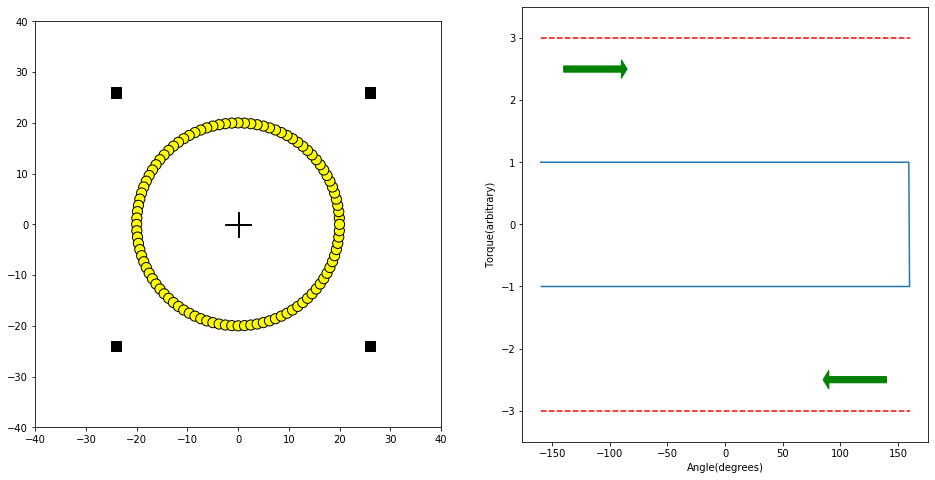

In [28]:
# Torque curve if perfectly balanced
Adds = [] # List of additional weights in (mass, X, Y) format
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
plotMasses(Basic, Adds, ax1)
calculateTorque(Basic, Adds, ax2, fudgeFactor=0.0005)
plt.savefig("/Users/cslage/Research/LSST/code/auxtel/mount_issues/rotator_faults/Perfectly_Balanced.pdf")

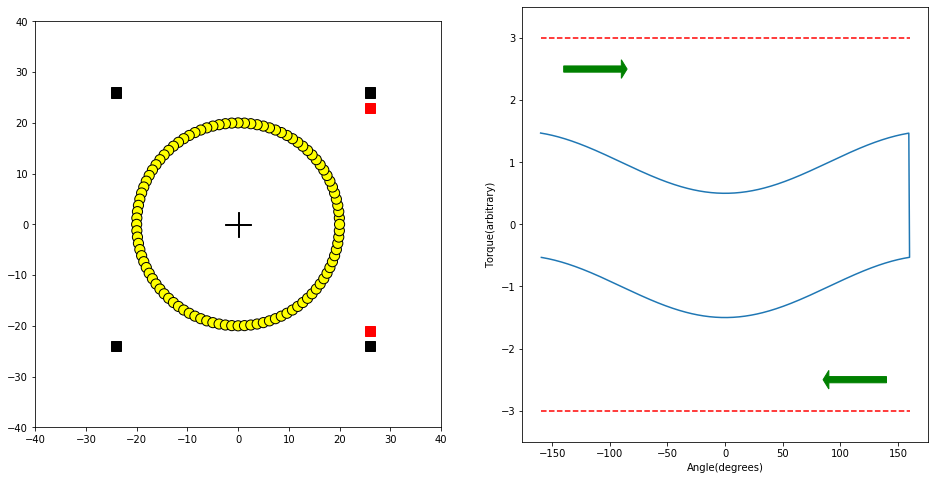

In [29]:
# Torque curve with more weight on right side
Adds = [(2.0, 25.0, 22.0), (2.0, 25.0, -22.0)] # List of additional weights in (mass, X, Y) format
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
plotMasses(Basic, Adds, ax1)
calculateTorque(Basic, Adds, ax2, fudgeFactor=0.0005)
plt.savefig("/Users/cslage/Research/LSST/code/auxtel/mount_issues/rotator_faults/Weight_Right.pdf")

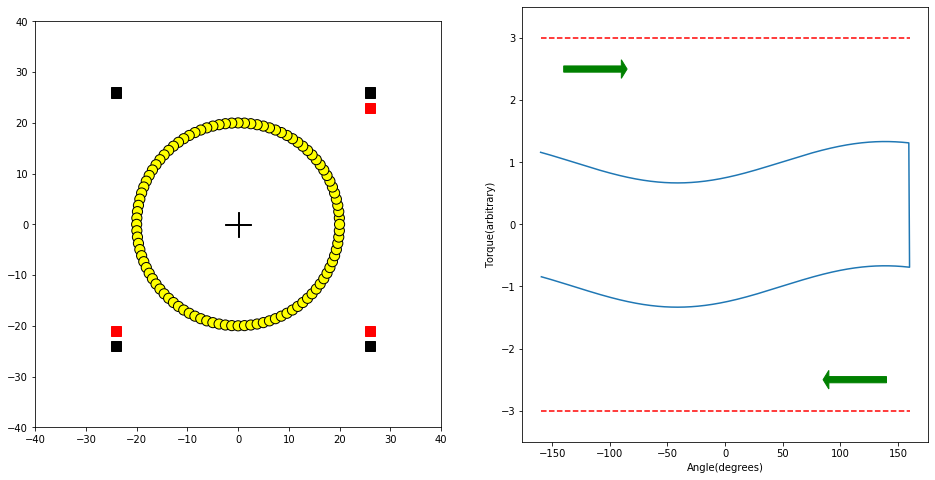

In [30]:
# Torque curve with C-clamps
Adds = [(2.0, 25.0, 22.0), (2.0, 25.0, -22.0), (2.0, -25.0, -22.0)] # List of additional weights in (mass, X, Y) format
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
plotMasses(Basic, Adds, ax1)
calculateTorque(Basic, Adds, ax2, fudgeFactor=0.0005)
plt.savefig("/Users/cslage/Research/LSST/code/auxtel/mount_issues/rotator_faults/CClamps.pdf")